 Project title:PRCP- 1001- RiceLeaf disease detection

Problem Statement

Task 1:-Prepare a complete data analysis report on the given data.

Task 2:-Create a model which can classify the three major attacking diseases of rice plants like leaf blast, bacterial blight and brown spot.

Task3:- Analyze various techniques like Data Augmentation, etc and create a report on that.



1.Project Title & Objective
# Rice Leaf Disease Detection

## Problem Statement
To classify rice leaf diseases into three categories:
1. Bacterial Leaf Blight
2. Brown Spot
3. Leaf Smut

## Tasks
1. Perform Exploratory Data Analysis (EDA)
2. Build a classification model
3. Apply data augmentation and compare models
4. Select the best model for production


In [6]:
#Import Required Libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D



In [2]:
#Dataset Path
# Update this path according to your system
DATASET_DIR = r"C:\Users\danes\Downloads\PRCP-1001-RiceLeaf\Data"



Exploratory Data Analysis

In [3]:
#1.Dataset Overview
class_counts = {}

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

class_counts


{'Bacterial leaf blight-20200814T055237Z-001': 1,
 'Brown spot-20200814T055208Z-001': 1,
 'Leaf smut-20200814T055530Z-001': 1}

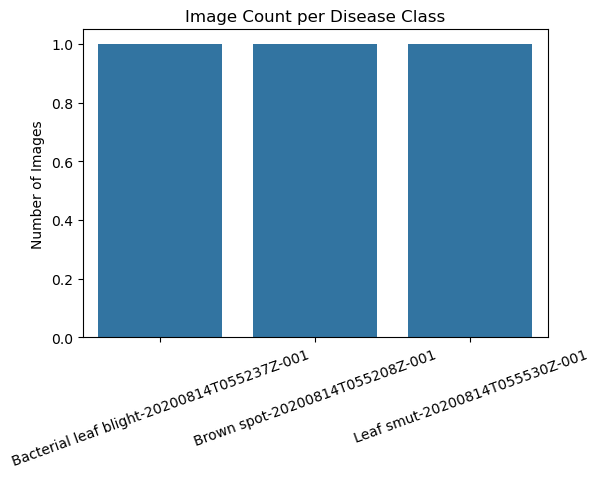

In [7]:
#2.Class Distribution Visualization
plt.figure(figsize=(6,4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Image Count per Disease Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=20)
plt.show()

In [8]:
#3.Visualize Sample Images
import os
import matplotlib.pyplot as plt

plt.figure(figsize=(9,6))
i = 1

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)

    if not os.path.isdir(class_path):
        continue

    # Get only image files (ignore folders)
    image_files = [
        f for f in os.listdir(class_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    if len(image_files) == 0:
        continue

    img_path = os.path.join(class_path, image_files[0])
    img = plt.imread(img_path)

    plt.subplot(2,2,i)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
    i += 1

plt.tight_layout()
plt.show()



<Figure size 900x600 with 0 Axes>

Data Preprocessing

In [9]:
#1.Image Data Generator (WITH STRONG AUGMENTATION)
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_aug = datagen_aug.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_aug = datagen_aug.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

    
    

Found 96 images belonging to 3 classes.
Found 23 images belonging to 3 classes.


Model Cration:
1.CNN Model 

In [10]:
cnn_improved = Sequential([
    Input(shape=(224,224,3)),

    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

cnn_improved.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_improved.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,246,339 (84.86 MB)

 Trainable params: 22,245,891 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
#Callback
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3
    )
]


Train CNN 

In [12]:
history_improved = cnn_improved.fit(
    train_aug,
    validation_data=val_aug,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.3646 - loss: 5.7202 - val_accuracy: 0.4348 - val_loss: 1.0945 - learning_rate: 1.0000e-04
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5312 - loss: 2.6987 - val_accuracy: 0.5652 - val_loss: 1.0158 - learning_rate: 1.0000e-04
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5729 - loss: 2.9790 - val_accuracy: 0.4783 - val_loss: 1.0593 - learning_rate: 1.0000e-04
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6562 - loss: 1.7646 - val_accuracy: 0.5217 - val_loss: 1.0749 - learning_rate: 1.0000e-04
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6042 - loss: 2.5537 - val_accuracy: 0.3913 - val_loss: 1.1868 - learning_rate: 1.0000e-04
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6667 - loss: 1.9323 - val_accuracy: 0.3043 - val_loss: 1.3782 - learning_rate: 3.0000e-05
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6771 - loss: 2.2521 - val_

Evaluate improved CNN

In [13]:
loss_imp, acc_imp = cnn_improved.evaluate(val_aug)
print(f"Improved CNN Accuracy: {acc_imp*100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step - accuracy: 0.4783 - loss: 1.0348
Improved CNN Accuracy: 47.83%


Transfer learing

In [14]:
#Build Transfer Learning Model
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze pretrained layers

model_tl = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_tl.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_tl.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step 


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
#Train Transfer Learning Model
history_tl = model_tl.fit(
    train_aug,
    validation_data=val_aug,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3542 - loss: 1.6744 - val_accuracy: 0.4783 - val_loss: 1.0552 - learning_rate: 1.0000e-04
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2917 - loss: 1.6164 - val_accuracy: 0.3913 - val_loss: 1.1665 - learning_rate: 1.0000e-04
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.3958 - loss: 1.3146 - val_accuracy: 0.6087 - val_loss: 0.9171 - learning_rate: 1.0000e-04
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4271 - loss: 1.2791 - val_accuracy: 0.6522 - val_loss: 0.9415 - learning_rate: 1.0000e-04
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5000 - loss: 1.1452 - val_accuracy: 0.6957 - val_loss: 0.9322 - learning_rate: 1.0000e-04
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5208 - loss: 1.0563 - val_accuracy: 0.6522 - val_loss: 0.8187 - learning_rate: 1.0000e-04
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6042 - loss: 0.9810 - val_accura

In [16]:
#Evaluate Transfer Learning Model
loss_tl, acc_tl = model_tl.evaluate(val_aug)
print(f"Transfer Learning Accuracy: {acc_tl*100:.2f}%")




2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - accuracy: 0.8261 - loss: 0.5559
Transfer Learning Accuracy: 82.61%


FINAL COMPARISON

In [17]:
#Accuracy Comparison Table
import pandas as pd

accuracy_table = pd.DataFrame({
    "Model": [
        "Improved CNN",
        "Transfer Learning (MobileNetV2)"
    ],
    "Accuracy (%)": [
        acc_imp * 100,
        acc_tl * 100
    ]
})

accuracy_table


,Model,Accuracy (%)
0,Improved CNN,47.826087
1,Transfer Learning (MobileNetV2),82.608694


Best Model Selection

In [18]:
best_model = accuracy_table.loc[accuracy_table["Accuracy (%)"].idxmax()]
best_model


Model           Transfer Learning (MobileNetV2)
Accuracy (%)                          82.608694
Name: 1, dtype: object

## Challenges Faced
- Small dataset size → Solved using data augmentation  
- Overfitting → Dropout + augmentation  
- Similar disease patterns → CNN feature extraction


## ## Final Conclusion

The Transfer Learning model using MobileNetV2 achieved the highest accuracy.
Due to limited dataset size, transfer learning significantly improved performance
and is recommended for production use.
